## This is a Seq2Seq modelthat uses LSTM to translate texts from English to Italian

### Content:
1. Importing libraries
2. Loading the dataset
3. Preprocessing the dataset
4. Build the vocab
5. Encode the dataset
6. Set dataloader
7. Build the network architecture
8. Train the model
9. Evaluate the model
10. Save the model

In [35]:
# -----------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import re

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# For loading datasets
from datasets import load_dataset

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
# Load the English-Italian translation pairs
dataset = load_dataset("opus_books", "en-it")
all_data = dataset["train"]

# Manually split into train/test
train_indices, test_indices = train_test_split(range(len(all_data)), test_size=0.1, random_state=42)

train_data = all_data.select(train_indices)
test_data = all_data.select(test_indices)

# Show a sample
print(f"Train size: {len(train_data)} | Test size: {len(test_data)}")
print("Sample EN:", train_data[0]['translation']['en'])
print("Sample IT:", train_data[0]['translation']['it'])


Train size: 29098 | Test size: 3234
Sample EN: "It is come now--I must give it to-night."
Sample IT: — È giunto; debbo darvelo stasera.


In [37]:
def preprocess_text(text):
    """Clean and tokenize the text"""
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep letters and spaces only
    tokens = word_tokenize(text)
    return tokens

# Preprocess training data
train_en = []
train_it = []

for sample in tqdm(train_data):
    src = sample['translation']['en']
    tgt = sample['translation']['it']
    
    src_tokens = preprocess_text(src)
    tgt_tokens = preprocess_text(tgt)
    
    train_en.append(src_tokens)
    train_it.append(tgt_tokens)

# Preprocess test data
test_en = []
test_it = []

for sample in tqdm(test_data):
    src = sample['translation']['en']
    tgt = sample['translation']['it']
    
    src_tokens = preprocess_text(src)
    tgt_tokens = preprocess_text(tgt)
    
    test_en.append(src_tokens)
    test_it.append(tgt_tokens)

print(f"Sample EN: {train_en[0]}")
print(f"Sample IT: {train_it[0]}")

100%|██████████| 3234/3234 [00:00<00:00, 3324.81it/s]

Sample EN: ['it', 'is', 'come', 'nowi', 'must', 'give', 'it', 'tonight']
Sample IT: ['giunto', 'debbo', 'darvelo', 'stasera']


In [38]:
### Each will have its own token-to-index and index-to-token mappings.
def build_vocab(sentences, max_words=30000):
    """Build a vocabulary of the most common words in the given tokenized sentences"""
    word_count = Counter()
    for sentence in sentences:
        word_count.update(sentence)

    most_common = word_count.most_common(max_words - 4)  # -4 for <PAD>, <UNK>, <SOS>, <EOS>
    vocab = {word: idx + 4 for idx, (word, _) in enumerate(most_common)}

    # Add special tokens
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    vocab['<SOS>'] = 2
    vocab['<EOS>'] = 3

    return vocab

# Build separate vocabularies
src_vocab = build_vocab(train_en)
tgt_vocab = build_vocab(train_it)

# Vocabulary sizes
src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)

print(f"Source vocab size (EN): {src_vocab_size}")
print(f"Target vocab size (IT): {tgt_vocab_size}")

# Reverse mappings
src_idx_to_word = {idx: word for word, idx in src_vocab.items()}
tgt_idx_to_word = {idx: word for word, idx in tgt_vocab.items()}


Source vocab size (EN): 24720
Target vocab size (IT): 30000


In [39]:
def encode_sequence(tokens, vocab, max_len=50, add_sos_eos=False):
    """Convert tokenized sentence to integer indices with optional <SOS> and <EOS>"""
    if add_sos_eos:
        tokens = ['<SOS>'] + tokens[:max_len - 2] + ['<EOS>']  # Reserve space for both
    else:
        tokens = tokens[:max_len]

    encoded = [vocab.get(word, vocab['<UNK>']) for word in tokens]

    # Pad if needed
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))

    return encoded

# Set max lengths
MAX_LEN_SRC = 50
MAX_LEN_TGT = 50

# Encode source (EN) and target (IT)
train_src_encoded = [encode_sequence(sent, src_vocab, max_len=MAX_LEN_SRC) for sent in tqdm(train_en)]
train_tgt_encoded = [encode_sequence(sent, tgt_vocab, max_len=MAX_LEN_TGT, add_sos_eos=True) for sent in train_it]

test_src_encoded = [encode_sequence(sent, src_vocab, max_len=MAX_LEN_SRC) for sent in tqdm(test_en)]
test_tgt_encoded = [encode_sequence(sent, tgt_vocab, max_len=MAX_LEN_TGT, add_sos_eos=True) for sent in test_it]

# Convert to tensors
train_src_tensor = torch.tensor(train_src_encoded, dtype=torch.long)
train_tgt_tensor = torch.tensor(train_tgt_encoded, dtype=torch.long)
test_src_tensor = torch.tensor(test_src_encoded, dtype=torch.long)
test_tgt_tensor = torch.tensor(test_tgt_encoded, dtype=torch.long)

print("Encoding complete!")
print(f"Example EN (ids): {train_src_tensor[0][:10]}")
print(f"Example IT (ids): {train_tgt_tensor[0][:10]}")


100%|██████████| 3234/3234 [00:00<00:00, 153955.23it/s]


Encoding complete!
Example EN (ids): tensor([   14,    28,    88, 14065,    98,   208,    14,  1244,     0,     0])
Example IT (ids): tensor([    2,  1024,  1139, 20802,  2631,     3,     0,     0,     0,     0])


In [40]:
class TranslationDataset(Dataset):
    def __init__(self, src_tensor, tgt_tensor):
        self.src_tensor = src_tensor
        self.tgt_tensor = tgt_tensor

    def __len__(self):
        return len(self.src_tensor)

    def __getitem__(self, idx):
        return self.src_tensor[idx], self.tgt_tensor[idx]

# Split source and target together
train_src, val_src, train_tgt, val_tgt = train_test_split(
    train_src_tensor, train_tgt_tensor, test_size=0.1, random_state=42
)

# Create datasets
train_dataset = TranslationDataset(train_src, train_tgt)
val_dataset = TranslationDataset(val_src, val_tgt)
test_dataset = TranslationDataset(test_src_tensor, test_tgt_tensor)

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"DataLoaders created! Training batches: {len(train_loader)}")

DataLoaders created! Training batches: 410


In [41]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: [B, hidden_dim]
        # encoder_outputs: [B, src_len, hidden_dim]

        # Transform decoder hidden state: [B, 1, hidden_dim]
        dec_hidden = decoder_hidden.unsqueeze(1)

        # Compute alignment scores: [B, src_len]
        energy = torch.bmm(self.attn(dec_hidden), encoder_outputs.transpose(1, 2)).squeeze(1)

        # Softmax over source tokens
        attn_weights = torch.softmax(energy, dim=1)  # [B, src_len]

        # Compute context vector as weighted sum of encoder outputs
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [B, hidden_dim]

        return context, attn_weights

In [42]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers=1, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, (hidden, cell)  # return all outputs for attention

In [43]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout=0.5):
        super().__init__()

        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=tgt_vocab['<PAD>'])

        # Decoder hidden size must match encoder hidden size × 2
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.attention = LuongAttention(hidden_dim)
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, cell, encoder_outputs):
        # input_token: [B] → [B, 1]
        input_token = input_token.unsqueeze(1)

        # Embedded input token
        embedded = self.dropout(self.embedding(input_token))  # [B, 1, emb_dim]

        # Pass through LSTM
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))  # output: [B, 1, hidden_dim * 2]

        # Get attention context vector (using decoder output & encoder outputs)
        context, _ = self.attention(output.squeeze(1), encoder_outputs)  # [B, hidden_dim * 2]

        # Concatenate LSTM output and context vector
        concat = torch.cat((output.squeeze(1), context), dim=1)  # [B, hidden_dim * 4]

        # Predict token
        prediction = self.fc_out(concat)  # [B, output_dim]

        return prediction, hidden, cell

In [44]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        tgt_vocab_size = self.decoder.output_dim

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        # Encode the source sentence
        encoder_outputs, (hidden, cell) = self.encoder(src)  # encoder_outputs: [B, src_len, hidden_dim * 2]

        # Merge bidirectional hidden states
        def merge_bidir_states(state):
            # state shape: [num_layers * 2, batch, hidden_dim]
            # merge every two layers from forward/backward into one
            return torch.cat(
                [torch.cat((state[i], state[i + 1]), dim=1).unsqueeze(0)
                 for i in range(0, state.size(0), 2)],
                dim=0
            )  # [num_layers, batch, hidden_dim * 2]

        hidden = merge_bidir_states(hidden)
        cell = merge_bidir_states(cell)

        # First input to the decoder is the <SOS> token
        input_token = tgt[:, 0]  # [batch_size]

        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell, encoder_outputs)
            outputs[:, t] = output

            teacher_force = np.random.rand() < teacher_forcing_ratio
            input_token = tgt[:, t] if teacher_force else output.argmax(1)

        return outputs

In [45]:
embedding_dim = 100
hidden_dim = 512
n_layers = 3
INPUT_DIM = src_vocab_size
OUTPUT_DIM = tgt_vocab_size
encoder = Encoder(INPUT_DIM, embedding_dim, hidden_dim, n_layers, dropout=0.5)
decoder = Decoder(OUTPUT_DIM, embedding_dim, hidden_dim * 2, n_layers, dropout=0.5)  # *2 if bidirectional
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(encoder, decoder, device).to(device)

print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(24720, 100, padding_idx=0)
    (lstm): LSTM(100, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(30000, 100, padding_idx=0)
    (lstm): LSTM(100, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (attention): LuongAttention(
      (attn): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (fc_out): Linear(in_features=2048, out_features=30000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


In [46]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
print("Loss function and optimizer defined for sequence-to-sequence model!")


Loss function and optimizer defined for sequence-to-sequence model!


In [56]:
def train(model, iterator, optimizer, criterion, clip=1.0, teacher_forcing_ratio=0.5):
    model.train()
    epoch_loss = 0
    total_tokens = 0
    correct_tokens = 0

    for src, tgt in tqdm(iterator, desc="Training", leave=False):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        output = model(src, tgt, teacher_forcing_ratio=teacher_forcing_ratio)  # [B, tgt_len, vocab_size]

        # Shift targets to exclude <SOS>
        output_dim = output.shape[-1]
        output_reshaped = output[:, 1:].reshape(-1, output_dim)  # [B*(tgt_len-1), vocab]
        tgt_reshaped = tgt[:, 1:].reshape(-1)                    # [B*(tgt_len-1)]

        loss = criterion(output_reshaped, tgt_reshaped)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        # Accuracy
        preds = output_reshaped.argmax(1)
        mask = tgt_reshaped != tgt_vocab['<PAD>']
        correct = (preds == tgt_reshaped) & mask
        correct_tokens += correct.sum().item()
        total_tokens += mask.sum().item()

    acc = correct_tokens / total_tokens if total_tokens > 0 else 0.0
    return epoch_loss / len(iterator), acc


In [57]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, tgt in tqdm(iterator, desc="Evaluating", leave=False):
            src, tgt = src.to(device), tgt.to(device)

            output = model(src, tgt, teacher_forcing_ratio=0)  # no teacher forcing in eval

            output_dim = output.shape[-1]
            output_reshaped = output[:, 1:].reshape(-1, output_dim)
            tgt_reshaped = tgt[:, 1:].reshape(-1)

            loss = criterion(output_reshaped, tgt_reshaped)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [58]:
best_val_loss = float('inf')
best_model_state = None
patience = 3
patience_counter = 0

n_epochs = 15

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    teacher_forcing_ratio = max(0.3, 0.7 * (0.95 ** epoch))  # decay each epoch

    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print("-" * 20)

    # Train
    train_loss, _ = train(model, train_loader, optimizer, criterion, teacher_forcing_ratio=teacher_forcing_ratio)
    train_losses.append(train_loss)

    # Validate
    val_loss = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)

    # Step scheduler (if used)
    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}.")
            break

print("\nTraining complete!")

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model restored (based on lowest validation loss).")


Epoch 1/15
--------------------


Train Loss: 4.2518
Val Loss: 7.4414

Epoch 2/15
--------------------


Train Loss: 4.1202
Val Loss: 7.5065

Epoch 3/15
--------------------


Train Loss: 3.9290
Val Loss: 7.5839

Epoch 4/15
--------------------


Train Loss: 3.8651
Val Loss: 7.5870

Early stopping triggered at epoch 4.

Training complete!
Best model restored (based on lowest validation loss).


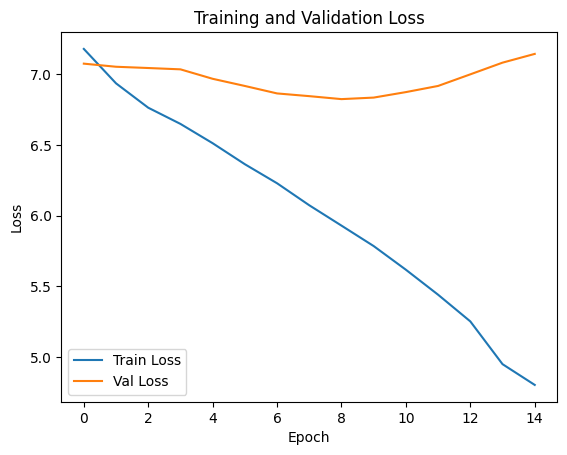

In [50]:
# Plot loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [51]:
def beam_search_translate(model, sentence, src_vocab, tgt_vocab, tokenizer, beam_width=3, max_len=50):
    model.eval()

    sos_token = tgt_vocab['<SOS>']
    eos_token = tgt_vocab['<EOS>']
    pad_token = tgt_vocab['<PAD>']

    src_tokens = ['<SOS>'] + tokenizer(sentence) + ['<EOS>']
    src_indices = [src_vocab.get(tok, src_vocab['<UNK>']) for tok in src_tokens]
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(model.device)

    with torch.no_grad():
        encoder_outputs, (hidden, cell) = model.encoder(src_tensor)

    def merge_bidir(state):
        return torch.cat([torch.cat((state[i], state[i+1]), dim=1).unsqueeze(0)
                          for i in range(0, state.size(0), 2)], dim=0)

    hidden = merge_bidir(hidden)
    cell = merge_bidir(cell)

    beams = [(torch.tensor([sos_token], device=model.device), hidden, cell, 0)]  # (sequence, hidden, cell, score)

    for _ in range(max_len):
        new_beams = []

        for seq, h, c, score in beams:
            if seq[-1].item() == eos_token:
                new_beams.append((seq, h, c, score))
                continue

            input_token = seq[-1].unsqueeze(0)  # [1] → will become [1, 1] when passed to embedding


            with torch.no_grad():
                output, h_new, c_new = model.decoder(input_token, h, c, encoder_outputs)
                probs = torch.log_softmax(output, dim=1)  # [1, vocab_size]
                topk_probs, topk_ids = probs.topk(beam_width)

            for i in range(beam_width):
                new_seq = torch.cat([seq, topk_ids[0, i].unsqueeze(0)])
                new_score = score + topk_probs[0, i].item()
                new_beams.append((new_seq, h_new, c_new, new_score))

        # Keep best `beam_width` beams
        beams = sorted(new_beams, key=lambda x: x[3], reverse=True)[:beam_width]

        # Optional early stop if all beams ended
        if all(b[0][-1].item() == eos_token for b in beams):
            break

    # Return the best beam
    best_seq = beams[0][0]
    tgt_idx_to_word = {idx: word for word, idx in tgt_vocab.items()}
    decoded = [tgt_idx_to_word.get(tok.item(), '<UNK>') for tok in best_seq if tok.item() not in [sos_token, eos_token, pad_token]]

    return ' '.join(decoded)

In [52]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, src_tokenizer, max_len=50):
    model.eval()

    tokens = src_tokenizer(sentence)
    tokens = ['<SOS>'] + tokens + ['<EOS>']
    src_indices = [src_vocab.get(tok, src_vocab['<UNK>']) for tok in tokens]
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(model.device)

    with torch.no_grad():
        encoder_outputs, (hidden, cell) = model.encoder(src_tensor)

    # Merge bidirectional states (same logic used in training)
    def merge_bidir(state):
        # state shape: [num_layers * 2, B, H]
        num_layers = state.size(0) // 2
        # Split and concat: [(fwd_0, bwd_0), (fwd_1, bwd_1), ...]
        return torch.cat([torch.cat((state[i], state[i+1]), dim=1).unsqueeze(0) 
                          for i in range(0, state.size(0), 2)], dim=0)
    

    hidden = merge_bidir(hidden)
    cell = merge_bidir(cell)

    input_token = torch.tensor([tgt_vocab['<SOS>']], dtype=torch.long).to(model.device)
    output_tokens = []

    for _ in range(max_len):
        with torch.no_grad():
            output, hidden, cell = model.decoder(input_token, hidden, cell, encoder_outputs)
            top1 = output.argmax(1).item()
            if top1 == tgt_vocab['<EOS>']:
                break
            output_tokens.append(top1)
            input_token = torch.tensor([top1], dtype=torch.long).to(model.device)

    # Invert vocab
    tgt_idx_to_word = {idx: word for word, idx in tgt_vocab.items()}
    translated_words = [tgt_idx_to_word.get(idx, '<UNK>') for idx in output_tokens]

    return ' '.join(translated_words)

example_sentences = [
    "Hello, how are you?",
    "I love machine learning.",
    "This book is very interesting.",
]

print("Translation examples:")
for sent in example_sentences:
    translated = beam_search_translate(model, sent, src_vocab, tgt_vocab, preprocess_text, beam_width=5)
    print(f"EN: {sent}")
    print(f"IT: {translated}")
    print("-" * 40)


Translation examples:
EN: Hello, how are you?
IT: in mare che avete visto
----------------------------------------
EN: I love machine learning.
IT: io sono agitato
----------------------------------------
EN: This book is very interesting.
IT: tutti sono impedito
----------------------------------------


In [53]:
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [54]:
def compute_bleu(model, data_loader, src_vocab, tgt_vocab, src_tokenizer, tgt_idx_to_word, max_len=50, num_samples=100):
    model.eval()
    references = []
    hypotheses = []

    count = 0
    smooth_fn = SmoothingFunction().method4

    for src, tgt in data_loader:
        src = src.to(model.device)
        tgt = tgt.to(model.device)

        for i in range(src.size(0)):
            if count >= num_samples:
                break

            # Convert to raw sentence
            src_tokens = [list(src_vocab.keys())[list(src_vocab.values()).index(idx.item())] for idx in src[i]]
            ref_tokens = [tgt_idx_to_word.get(tok.item(), '<UNK>') for tok in tgt[i] if tok.item() not in [tgt_vocab['<PAD>'], tgt_vocab['<SOS>']]]

            # Generate hypothesis from model
            src_sentence = ' '.join([k for k in src_tokens if k not in ['<PAD>', '<SOS>', '<EOS>']])
            pred = beam_search_translate(model, src_sentence, src_vocab, tgt_vocab, src_tokenizer, beam_width=5, max_len=max_len)
            pred_tokens = pred.strip().split()

            references.append([ref_tokens])
            hypotheses.append(pred_tokens)
            count += 1

    bleu = corpus_bleu(references, hypotheses, smoothing_function=smooth_fn)
    return bleu

In [55]:
tgt_idx_to_word = {idx: word for word, idx in tgt_vocab.items()}
bleu_score = compute_bleu(model, val_loader, src_vocab, tgt_vocab, preprocess_text, tgt_idx_to_word, num_samples=100)
print(f"\nCorpus BLEU Score (on 100 samples): {bleu_score * 100:.2f}")


Corpus BLEU Score (on 100 samples): 0.63
